In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sqlite3
import re
import sys
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
loan_db = pd.read_csv('loan.csv', low_memory=False)


In [3]:
loan_db.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [4]:
#Since our database is full of irrelevant attributes, we will be dropping most of them, and saving only the relevant ones
relevant_columns = [
    'id', 'member_id', 'loan_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
    'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state',
    'dti', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
    'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
    'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d']

loan_db = loan_db[relevant_columns]


In [22]:
#Checking for missing values 
print(loan_db.isnull().sum())

id                         0
member_id                  0
loan_amnt                  0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
emp_length                 0
home_ownership             0
annual_inc                 0
verification_status        0
loan_status                0
purpose                    0
title                      0
zip_code                   0
addr_state                 0
dti                        0
earliest_cr_line           0
inq_last_6mths             0
open_acc                   0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_d               0
last_pymnt_amnt            0
last_credit_pu

In [ ]:
#Filling Missing Values

for column in loan_db.select_dtypes(include=['float64', 'int64']).columns:
    loan_db[column].fillna(loan_db[column].mean(), inplace=True)

for column in loan_db.select_dtypes(include=['object']).columns:
    loan_db[column].fillna(loan_db[column].mode()[0], inplace=True)

In [10]:
loan_db.head()

,id,member_id,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,...,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d
0,1077501,1296599,5000,4975.0,36 months,10.65%,162.87,B,10+ years,RENT,...,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,May-16
1,1077430,1314167,2500,2500.0,60 months,15.27%,59.83,C,< 1 year,RENT,...,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13
2,1077175,1313524,2400,2400.0,36 months,15.96%,84.33,C,10+ years,RENT,...,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,May-16
3,1076863,1277178,10000,10000.0,36 months,13.49%,339.31,C,10+ years,RENT,...,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,Apr-16
4,1075358,1311748,3000,3000.0,60 months,12.69%,67.79,B,1 year,RENT,...,3513.330000,3513.33,2475.94,1037.39,0.00,0.00,0.00,May-16,67.79,May-16


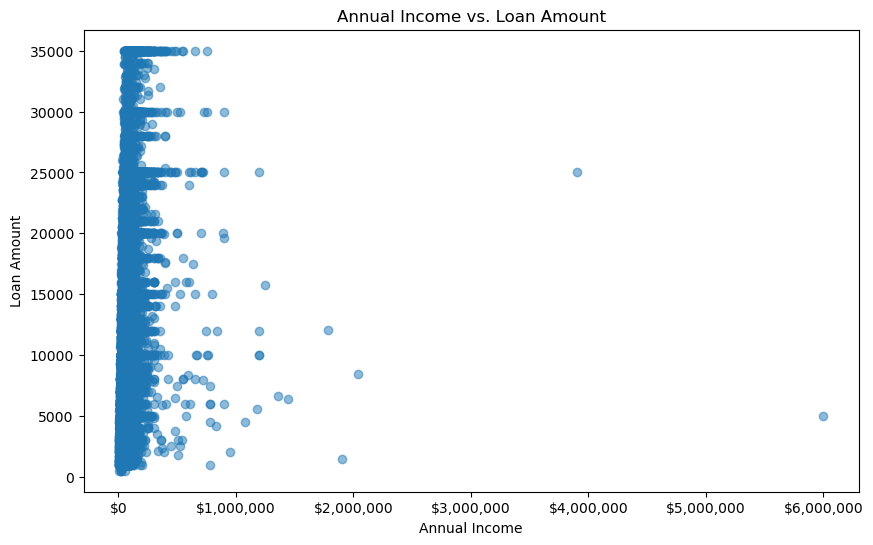

In [18]:
#Looking for a correlation between the annual income and loan amount but barely any is found
from matplotlib.ticker import FuncFormatter

def currency(x, pos):
    return '${:,.0f}'.format(x)

formatter = FuncFormatter(currency)

plt.figure(figsize=(10, 6))
plt.scatter(loan_db['annual_inc'], loan_db['loan_amnt'], alpha=0.5)
plt.title('Annual Income vs. Loan Amount')
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')

plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

<Figure size 1200x600 with 0 Axes>

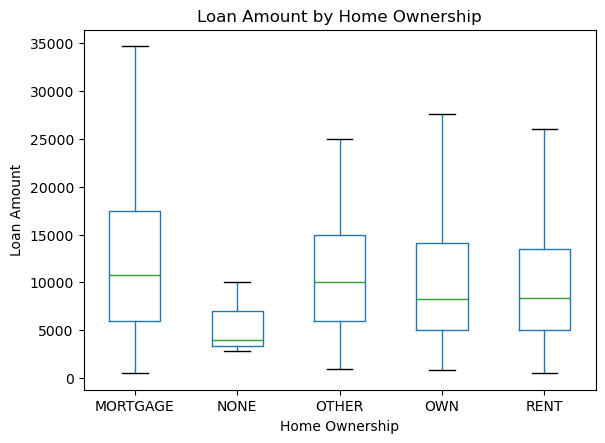

In [20]:
#Looking for a correlation between the loan amount and the type of Home Ownership but it's mostly not existant
plt.figure(figsize=(12, 6))
loan_db.boxplot(column='loan_amnt', by='home_ownership', grid=False, showfliers=False)
plt.title('Loan Amount by Home Ownership')
plt.suptitle('')
plt.xlabel('Home Ownership')
plt.ylabel('Loan Amount')
plt.show()

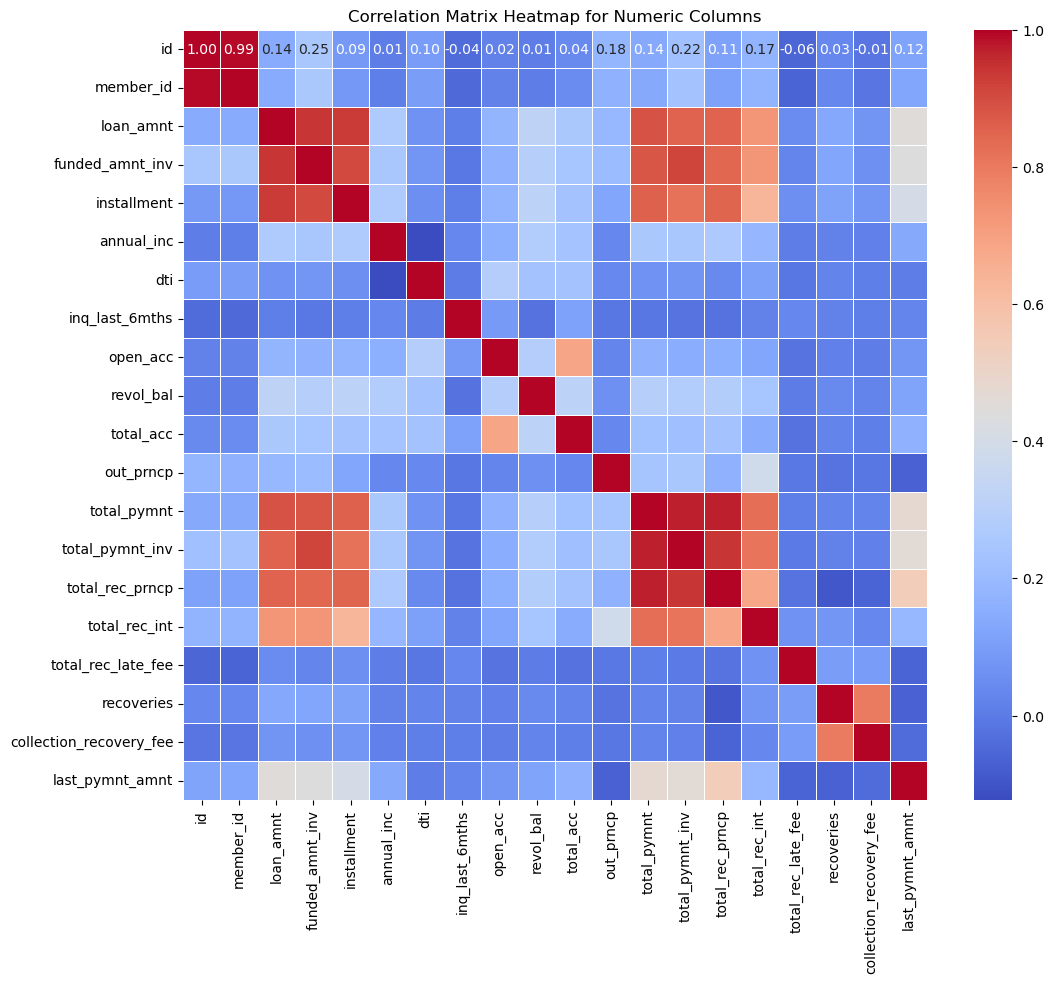

In [39]:
#Checking for overall correlations
numeric_df = loan_db.select_dtypes(include=['int64', 'float64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap for Numeric Columns')
plt.show()

In [23]:
#y is going to be our testing/output data
y = loan_db['loan_status']

In [24]:
#X is going to be our training/input data
X = loan_db.drop('loan_status', axis=1)

In [25]:
#converting categorical variables into indicator variables
X = pd.get_dummies(X, drop_first=True)

In [26]:
#splitting the data into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
#setting the random state so every time the code is ran we get the same results
model = RandomForestClassifier(random_state=42)
#inital training the model
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
#hyperparameter Tuning (optional if we are not happy with the initial training)
"""
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_#
"""

In [28]:
#making predictions on the test data using the trained model
y_pred = model.predict(X_test)

In [29]:
#checking the accuracy of the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.9837613293051359
Classification Report:
               precision    recall  f1-score   support

 Charged Off       1.00      0.89      0.94      1094
     Current       1.00      0.97      0.98       262
  Fully Paid       0.98      1.00      0.99      6588

    accuracy                           0.98      7944
   macro avg       0.99      0.95      0.97      7944
weighted avg       0.98      0.98      0.98      7944



In [32]:
#realising the model is overfitting, so we limit the model complexity

model = RandomForestClassifier(random_state=42, max_depth=10, n_estimators=100, max_features='sqrt', class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Training Accuracy: 0.9365499008592201
Test Accuracy: 0.9284994964753273
Classification Report:
               precision    recall  f1-score   support

 Charged Off       0.76      0.94      0.84      1094
     Current       0.57      1.00      0.72       262
  Fully Paid       0.99      0.92      0.96      6588

    accuracy                           0.93      7944
   macro avg       0.77      0.95      0.84      7944
weighted avg       0.95      0.93      0.93      7944



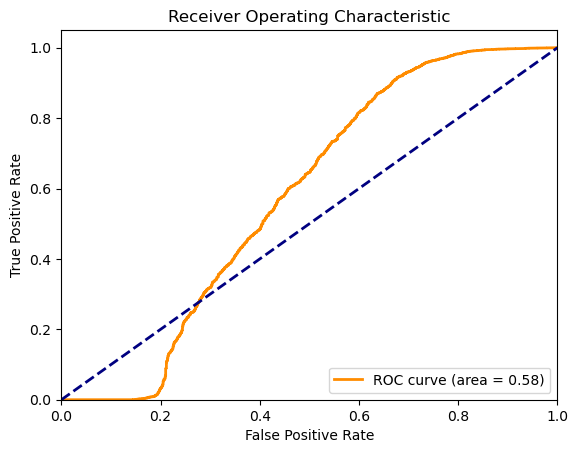

In [36]:
#evaluating the performance of the model, realising the result is satisfying
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1], pos_label='Fully Paid')
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()